In [1]:
import sys
import os

if 'google.colab' in sys.modules:
    !pip install idaes-pse --pre
    !idaes get-extensions --to ./bin
    os.environ['PATH'] += ':bin'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import yfinance as yf
from pyomo.environ import *

def BDM_Project(tickers, start_date, end_date, initial_return_range=(0.005, 0.03), step=0.001):
    """
    Downloads stock data, analyzes returns, and models efficient frontier until full concentration.

    Parameters:
    - tickers: list of stock tickers
    - start_date: 'YYYY-MM-DD'
    - end_date: 'YYYY-MM-DD'
    - initial_return_range: tuple of min and initial max target returns
    - step: increment for sweeping return targets

    Returns:
    - Dictionary with returns, matrices, frontier, and allocation data
    """
    # === Step 1: Download and prepare data ===
    price_data = {}
    for t in tickers:
        try:
            df = yf.download(t, start=start_date, end=end_date, interval="1d", progress=False, auto_adjust=False)
            if not df.empty and 'Adj Close' in df.columns:
                price_data[t] = df['Adj Close']
            else:
                print(f"Warning: no valid data for {t}")
        except Exception as e:
            print(f"Failed {t}: {e}")

    if not price_data:
        print("No valid data retrieved.")
        return None

    prep_data = pd.concat(price_data.values(), axis=1)
    prep_data.columns = list(price_data.keys())

    if prep_data.empty or prep_data.isnull().all().all():
        print("No valid adjusted close data available. Aborting.")
        return None

    # === Step 2: Return calculations ===
    daily_returns = prep_data.pct_change().dropna()
    log_returns = np.log(prep_data / prep_data.shift(1)).dropna()
    monthly_returns = prep_data.resample('M').ffill().pct_change().dropna()
    avg_return = monthly_returns.mean()
    cov_matrix = monthly_returns.cov()
    cor_matrix = monthly_returns.corr()

    # === Step 3: Visual diagnostics ===
    (1 + daily_returns).cumprod().plot(figsize=(15, 10))
    plt.title('Cumulative Percentage Returns Over Time')
    plt.xlabel('Date'); plt.ylabel('Cumulative Return'); plt.grid(True); plt.tight_layout(); plt.show()

    daily_returns.plot(subplots=True, grid=True, layout=(4, 4), figsize=(15, 15))
    plt.suptitle('Daily Simple Returns'); plt.tight_layout(); plt.show()

    monthly_returns.plot(figsize=(15, 6), title='Monthly Returns')
    plt.grid(True); plt.tight_layout(); plt.show()

    plt.figure(figsize=(15, 12))
    sns.heatmap(cov_matrix, annot=True, cmap='coolwarm', fmt=".4f", center=0)
    plt.title('Covariance Matrix of Monthly Returns'); plt.tight_layout(); plt.show()

    plt.figure(figsize=(15, 12))
    sns.heatmap(cor_matrix, annot=True, cmap='coolwarm', fmt=".4f", center=0)
    plt.title('Correlation Matrix of Monthly Returns'); plt.tight_layout(); plt.show()

    # === Step 4: Optimization model builder ===
    def build_model(target_return):
        m = ConcreteModel()
        m.assets = Set(initialize=tickers)
        m.x = Var(m.assets, domain=NonNegativeReals, bounds=(0, 1))

        def portfolio_variance(m):
            return sum(m.x[i] * cov_matrix.loc[i, j] * m.x[j] for i in m.assets for j in m.assets)
        m.obj = Objective(rule=portfolio_variance, sense=minimize)

        m.total_allocation = Constraint(expr=sum(m.x[i] for i in m.assets) == 1)
        m.target_return = Constraint(expr=sum(m.x[i] * avg_return[i] for i in m.assets) >= target_return)

        return m

    def solve_and_extract(m):
        SolverFactory("ipopt").solve(m)
        solution = {i: m.x[i].value for i in m.assets}
        port_return = sum(solution[i] * avg_return[i] for i in m.assets)
        port_variance = sum(solution[i] * cov_matrix.loc[i, j] * solution[j] for i in m.assets for j in m.assets)
        port_risk = np.sqrt(port_variance)
        return solution, port_return, port_risk

    # === Step 5: Adaptive sweep until full concentration ===
    min_r, max_r = initial_return_range
    current_r = min_r
    results = []
    max_concentration_reached = False

    while not max_concentration_reached and current_r <= max_r + 0.1:
        m = build_model(target_return=current_r)
        result = SolverFactory("ipopt").solve(m)
        if result.solver.termination_condition != TerminationCondition.optimal:
            print(f"Skipping return target {current_r:.4f} — infeasible.")
            current_r += step
            continue
        try:
            solution, port_return, port_risk = solve_and_extract(m)
            clean_weights = {t: solution.get(t, 0.0) or 0.0 for t in tickers}
            results.append({
                "target_return": current_r,
                "actual_return": port_return,
                "risk": port_risk,
                "weights": clean_weights
            })

            # Check for full concentration
            nonzero_weights = [w for w in clean_weights.values() if w >= 0.01]
            if len(nonzero_weights) == 1 and abs(nonzero_weights[0] - 1.0) < 0.01:
                max_concentration_reached = True
        except Exception as e:
            print(f"Error at return {current_r:.4f}: {e}")
        current_r += step

    if not results:
        print("No feasible portfolios found.")
        return None

    # === Step 6: Plot efficient frontier ===
    frontier_df = pd.DataFrame(results).dropna().sort_values("risk")
    plt.figure(figsize=(8, 5))
    plt.plot(frontier_df["risk"], frontier_df["actual_return"], marker='o', linestyle='-', color='blue')
    plt.title("Efficient Frontier")
    plt.xlabel("Portfolio Risk (Standard Deviation)")
    plt.ylabel("Expected Return")
    plt.grid(True)
    plt.gca().xaxis.set_major_formatter(mtick.FormatStrFormatter('%.3f'))
    plt.tight_layout()
    plt.show()

    # === Step 7: Plot full allocation chart (indexed by risk) ===
    alloc_data = []
    for r in results:
        weights = {t: r["weights"].get(t, 0.0) for t in tickers}
        alloc_data.append(weights)

    alloc_df = pd.DataFrame(alloc_data, index=[r["risk"] for r in results])
    alloc_df = alloc_df.sort_index()

    plt.figure(figsize=(12, 6))
    for col in alloc_df.columns:
        plt.plot(alloc_df.index, alloc_df[col], label=col)
    plt.title("Asset Allocation vs. Portfolio Risk (Spaghetti Plot)")
    plt.xlabel("Portfolio Risk (Standard Deviation)")
    plt.ylabel("Weight")
    plt.grid(True)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.gca().xaxis.set_major_formatter(mtick.FormatStrFormatter('%.3f'))
    plt.tight_layout()
    plt.show()

    return {
        "daily_returns": daily_returns,
        "log_returns": log_returns,
        "monthly_returns": monthly_returns,
        "covariance_matrix": cov_matrix,
        "correlation_matrix": cor_matrix,
        "efficient_frontier": frontier_df,
        "allocations": alloc_df
    }

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.8/306.8 kB 9.3 MB/s eta 0:00:00
Getting files...
Done
-----------------------------------------------------------------
IDAES Extensions Build Versions
Solvers:  v3.4.2 20240811 ubuntu2204-x86_64
Library:  v3.4.2 20240811 ubuntu2204-x86_64



/tmp/ipython-input-2773606007.py:56: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = prep_data.resample('M').ffill().pct_change().dropna()


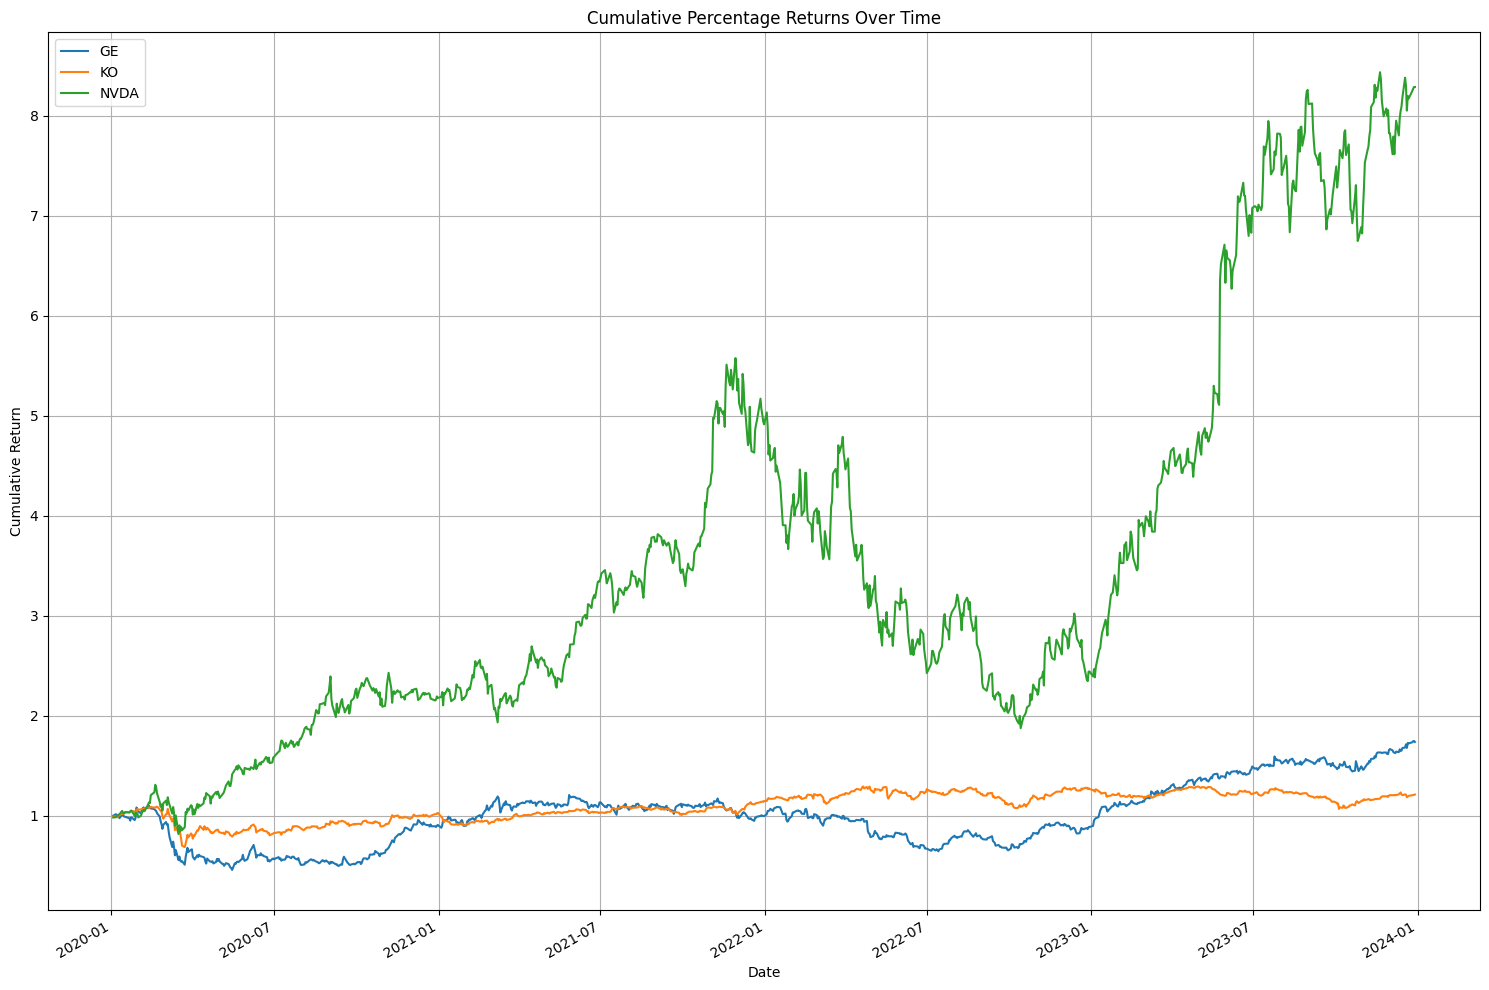

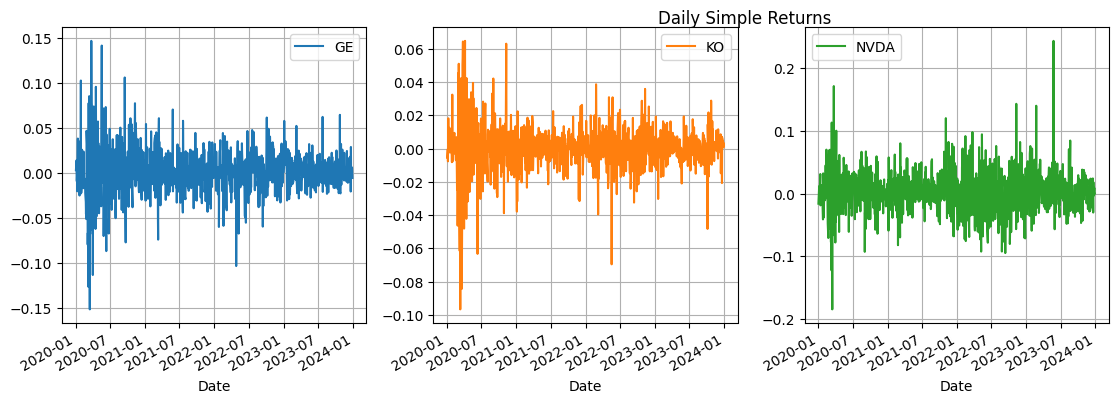

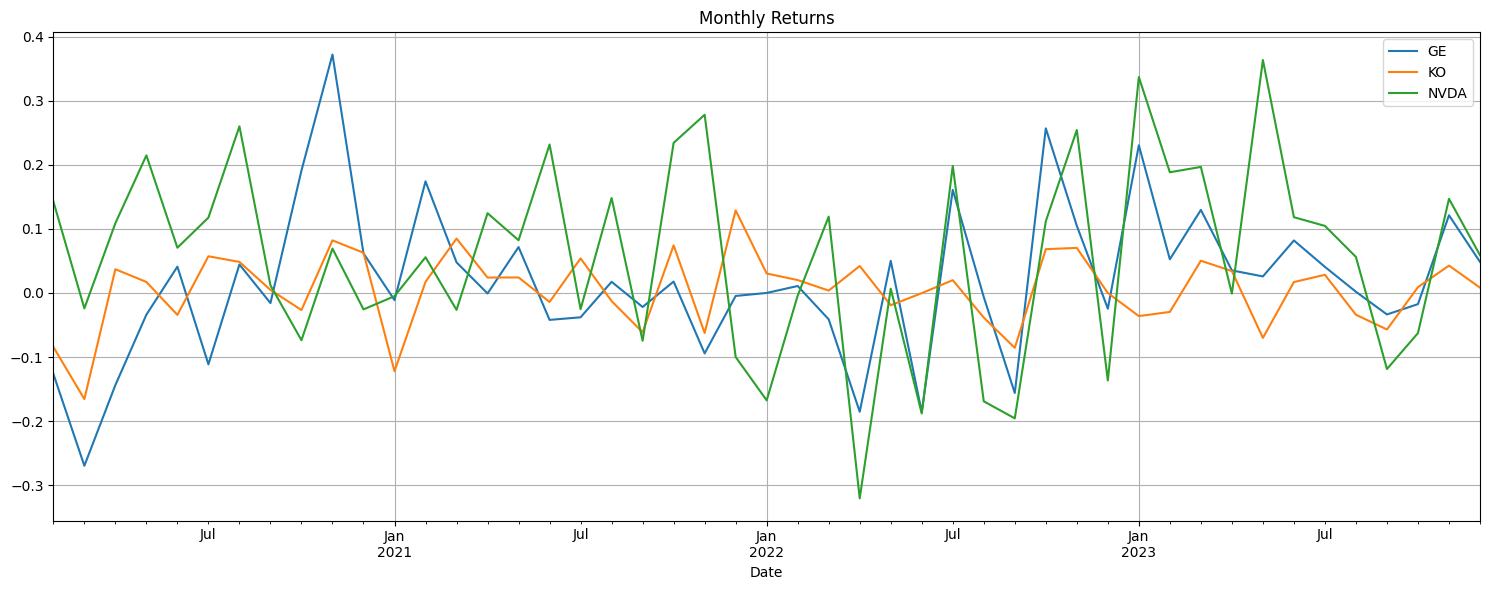

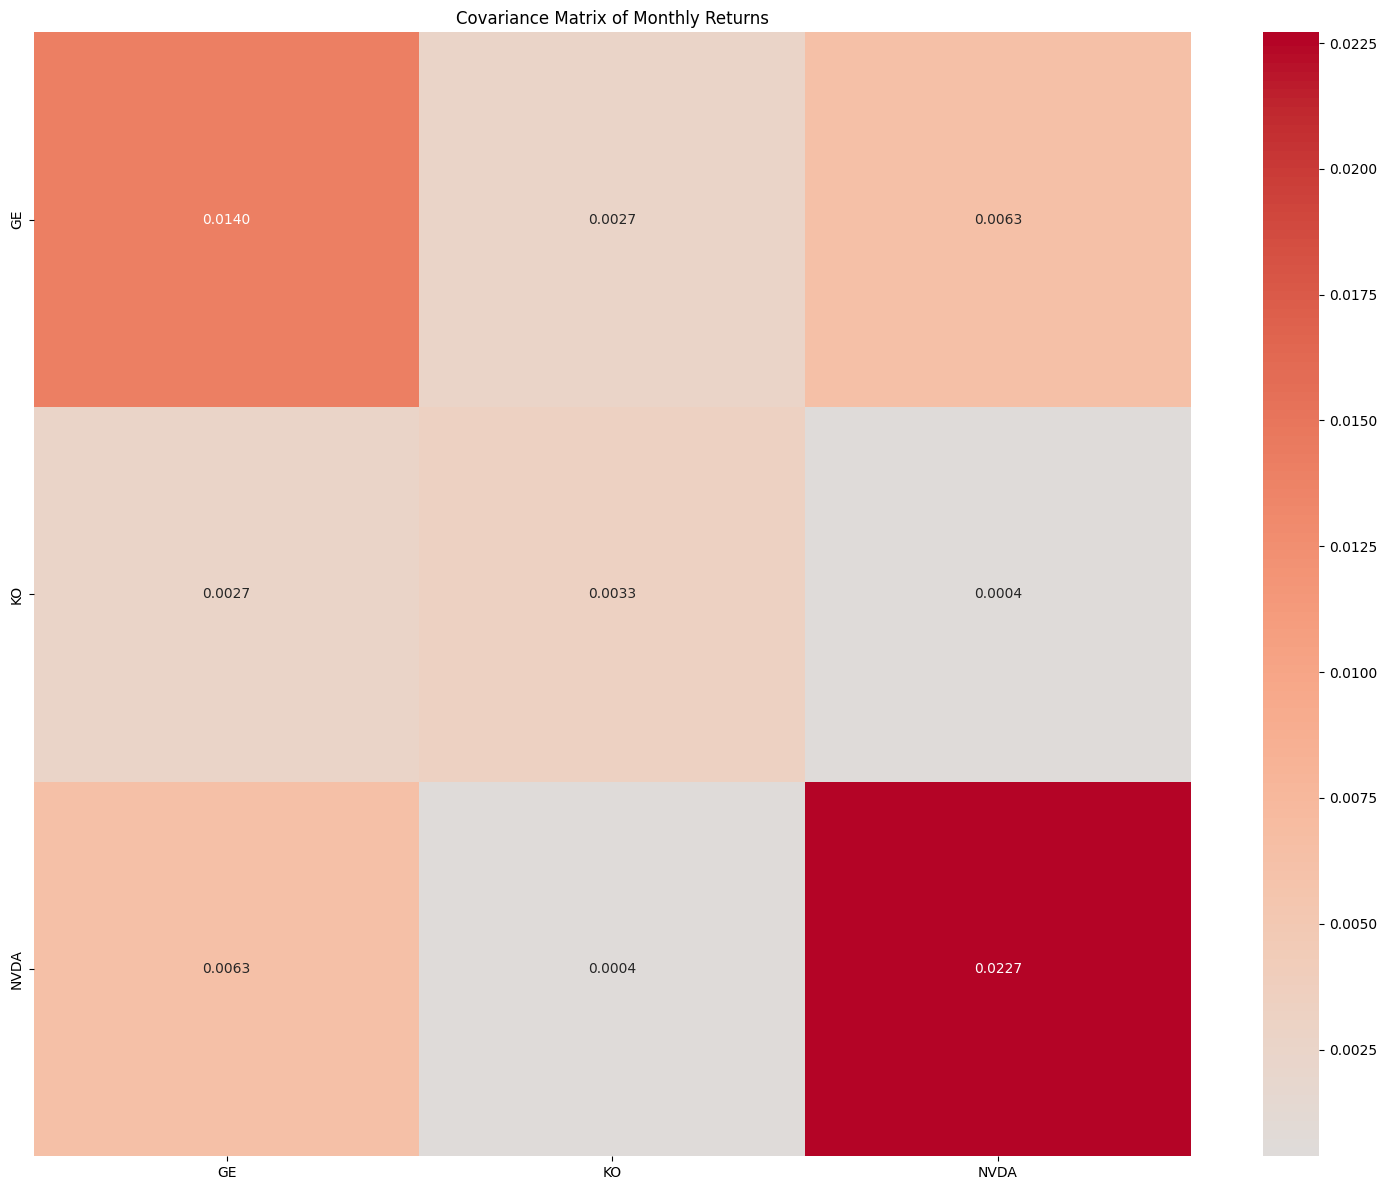

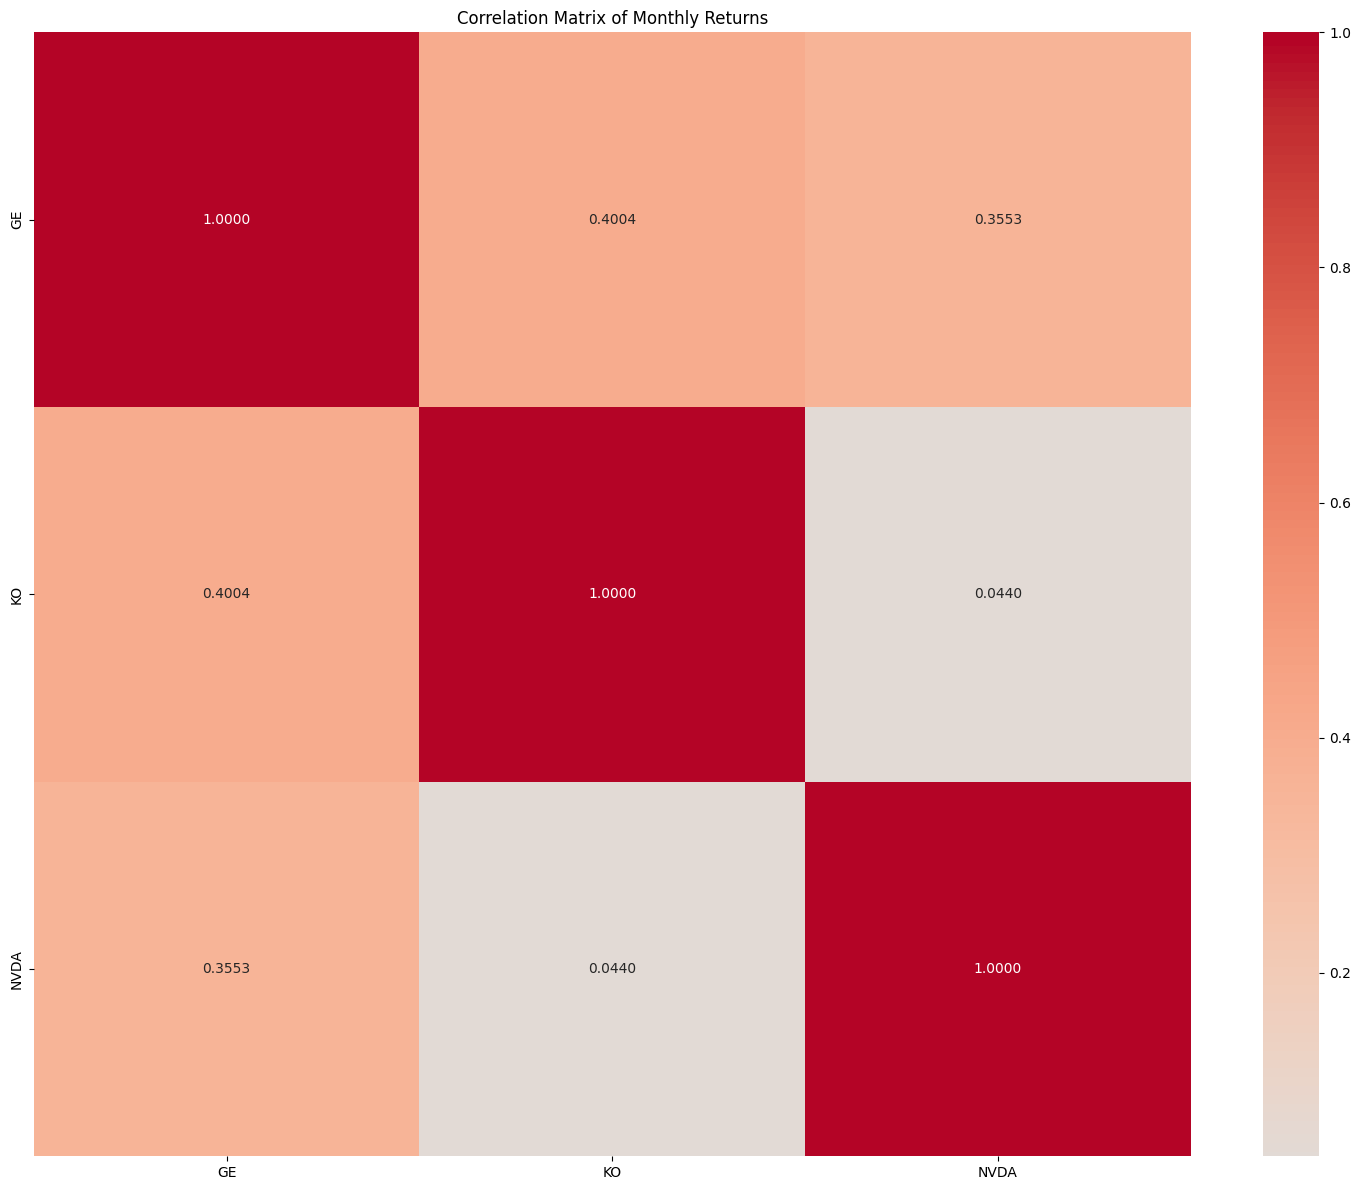

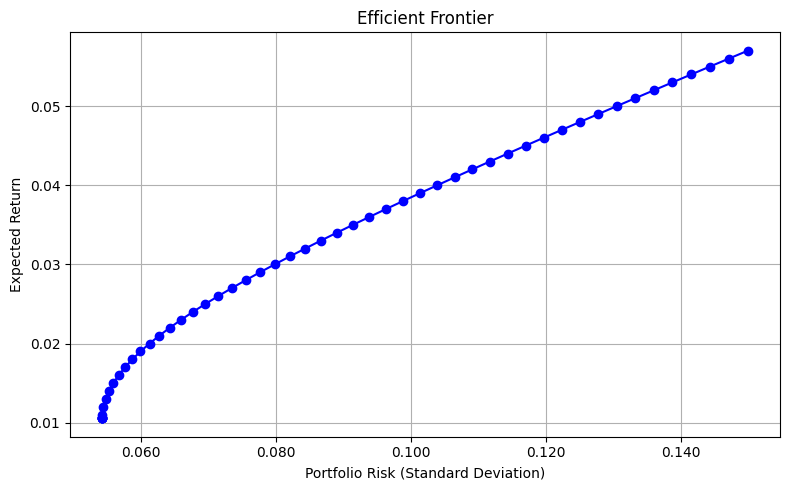

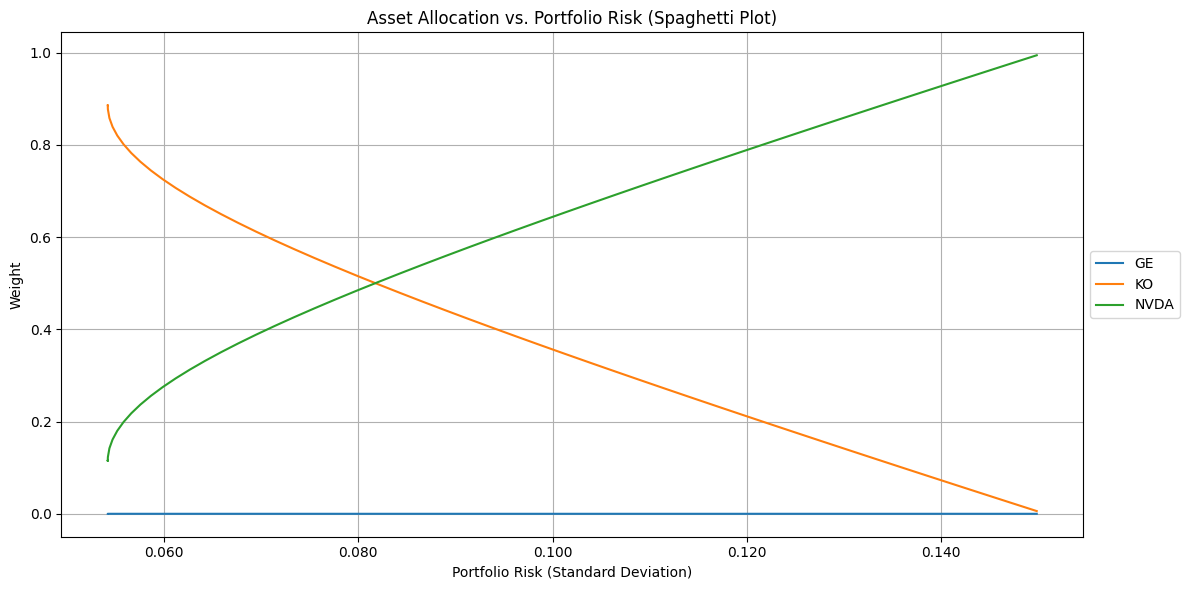

{'daily_returns':                   GE        KO      NVDA
 Date                                    
 2020-01-03  0.003353 -0.005456 -0.016006
 2020-01-06  0.014202 -0.000366  0.004194
 2020-01-07 -0.007414 -0.007682  0.012107
 2020-01-08 -0.009129  0.001843  0.001875
 2020-01-09 -0.002513  0.018215  0.010983
 ...              ...       ...       ...
 2023-12-22 -0.002205  0.005691 -0.003266
 2023-12-26  0.006157  0.004115  0.009195
 2023-12-27  0.006359  0.002561  0.002800
 2023-12-28  0.000936  0.000681  0.002125
 2023-12-29 -0.005377  0.003064  0.000000
 
 [1005 rows x 3 columns],
 'log_returns':                   GE        KO      NVDA
 Date                                    
 2020-01-03  0.003347 -0.005470 -0.016135
 2020-01-06  0.014102 -0.000366  0.004185
 2020-01-07 -0.007441 -0.007712  0.012034
 2020-01-08 -0.009170  0.001842  0.001874
 2020-01-09 -0.002516  0.018052  0.010923
 ...              ...       ...       ...
 2023-12-22 -0.002208  0.005674 -0.003271
 2023-12-26  0.0

In [ ]:
BDM_Project(['GE', 'KO', 'NVDA'], "2020-01-01", "2024-01-01")